# Pete's Princeton Python Plots

A Jupyter Notebook is an interactive Python environment where text, code and it's output can be displayed and shared online.

This Jupyter notebook will show you how to produce some interesting analyses of geoengineering data.

In [1]:
"""
This is a code cell.

First we import the libraries we need
"""

# Import general modules

import numpy as np
import sys
import os.path
from netCDF4 import Dataset

# Import analysis modules

from scipy.stats import ttest_ind_from_stats

# Import plotting modules

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm

from mpl_toolkits.basemap import Basemap

# Import dedicated functions I wrote for this project.

from Functions import *

In [2]:
# This let's us display matplotlib images more easily
%matplotlib inline

# Our data

We will be looking at data from 3 different experiments: A pre-industrial control (piControl or ctl), A high-CO2 experiment (abrupt4xCO2 or CO2), and a high-CO2 experiment with solar geoengineering (G1 or Geo100).

In [3]:
exp_list = ['ctl', 'CO2', 'Geo100']
exp_filename = {'ctl':'piControl','CO2':'abrupt4xCO2','Geo100':'G1'}

We will be looking at output from one model - NorESM1-M. This is only one of the 12 models which completed the Geoengienering Model Intercomparison Project (GeoMIP) G1 experiment. We use for the sake of simplicity here.

We have data for 5 different variables:
- 2m surface air temperature (tas)
- The annual maximum of the daily max surface air temperature (txx)
- Precipitation (pr)
- The annual maximum of consecutive 5-day precipitation (rx5day)
- Precipitation minus evaporation (p-e)

In [4]:
"""
Here we set a number of variable-specific settings
"""

var_list = ['tas', 'txx', 'pr', 'rx5day', 'p-e']
# the name of the variable in filenames:
var_filename = {'tas':'tas_Amon', 'txx':'txxETCCDI_yr', 'pr':'pr_Amon', 'rx5day':'rx5dayETCCDI_yr', 'p-e':'p-e_Amon'}
# the name of the variable inside the file:
var_internal = {'tas':'tas', 'txx':'txxETCCDI', 'pr':'pr', 'rx5day':'rx5dayETCCDI', 'p-e':'pr'}
# long name of the variable for plots
var_longname = {'tas':'2m Temperature','txx':'Max 2m Temperature','pr':'Precipitation','rx5day':'5-Day Max Precip.','p-e':'Precip. - Evap.'}

# Offsets and multiplication factors to get to degrees celcius and mm/day for all variables:
var_offsets = {'tas':-273.15, 'pr':0.0, 'rx5day':0.0, 'txx':0.0, 'p-e':0.0}
var_mults = {'tas':1.0, 'pr':60.0*60.0*24.0, 'rx5day':1.0, 'txx':1.0, 'p-e':60.0*60.0*24.0}

We will be looking at the annual-average data for the last 40 years of the model simulations for all experiments and variables. We will use both the average and standard deviation of this data which I've pre-processed. All netcdf files are in the data folder.

In [5]:
stat_list = ['mean','std']

In [46]:
"""
We will store all data in one "dictionary" to make it easier to access later.
"""

# Define a dictionary to store all data
all_data = {}

for exp in exp_list: # Loop over all experiments
    for var in var_list: # Loop over all variables
        for stat in stat_list: # Loop over all stats
            
            # Store all data in the dictionary
            all_data[exp,var,stat] = var_mults[var] * get_2d_geomip(var_filename[var], exp_filename[exp], stat, var_internal[var]) + var_offsets[var]

# NOTE - for loops, etc. in Python are closed by ending the associated indent.

In [7]:
# Then get latitudes and longitudes.
dummy, lats, lons = get_2d_geomip(var_filename['tas'], 'G1', 'mean', var_internal['tas'], lon_lat=True)

# A first check of our data

imshow() is a really simple function to plot out 2D data. Let's use it to look at surface air temperature in the control.

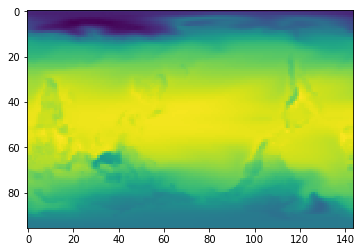

In [8]:
plot_data = all_data['ctl','tas','mean']

# this command generates the image
plt.imshow(plot_data)

The data is there but it's plotting upside down (The cold Antarctic is on top and Greenland is bottom right). We can do better.

Basemap produces much better map plots but requires more setting up.

In [9]:
"""
This function will setup basemap to produce a decent map of whatever variable we want. 
It will return a map object onto which we can plot things, and x,y coordinates for our data.
"""

def map_setup(lons, lats):

    # basemap needs 2D coordinate arrays
    lons2, lats2 = np.meshgrid(lons,lats)

    # We'll use a cylindrical projection
    m = Basemap(projection='cyl',llcrnrlat=-90,urcrnrlat=90,\
                    llcrnrlon=0,urcrnrlon=360,resolution='c')

    fig = plt.figure(figsize=(9,4))
    m.drawmapboundary(fill_color='white')

    # we'll draw coastlines onto our map
    m.drawcoastlines()

    # We'll also draw parallels and meridians
    m.drawparallels(np.arange(-90,120,30),labels=[1,0,0,0])
    m.drawmeridians(np.arange(m.lonmin,m.lonmax+30,60),labels=[0,0,0,1])

    x, y = m(lons2, lats2)

    return m, x, y

C:\Users\pjirv\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3608: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
C:\Users\pjirv\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3677: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


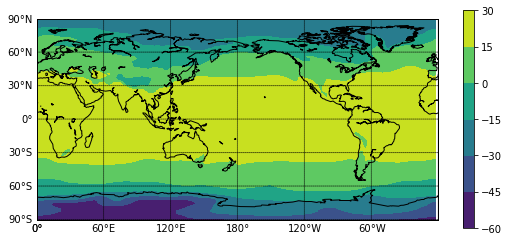

In [10]:
"""
let's plot the control surface air temperature again but with basemap
"""

plot_data = all_data['ctl','tas','mean']

# Use map setup function to set up map. 
m, x, y = map_setup(lons, lats)

# Produce a contour plot using the plot_data
m.contourf(x,y,plot_data)

# Add a color bar.
plt.colorbar()

# Maps of the basic climate response to solar geoengineering

How well does solar geoengineering reverse the effects of climate change? Let's plot the surface air temperature anomalies of CO2 - control and CO2&100%Geo - control.

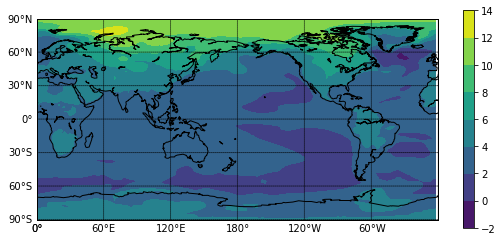

In [11]:
var = 'tas'

plot_data = all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']

# Use map setup function then produce a contour plot using the plot_data with a colorbar and show.
m, x, y = map_setup(lons, lats)
m.contourf(x,y,plot_data)
plt.colorbar()

Let's improve the plot by setting the colors and the color bar levels

In [12]:
# define a function to set colorbar levels
def level_func(min, max, step):
    return np.arange(min, max+step, step)

## Figure 1 - Maps of surface air temperature anomalies

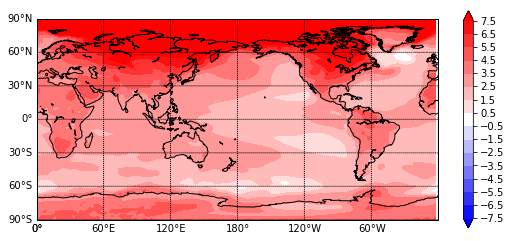

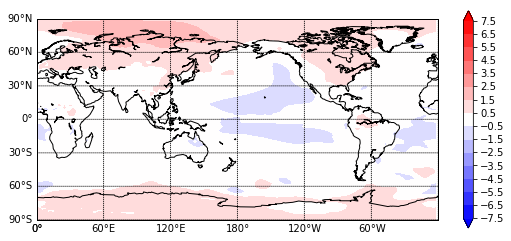

In [13]:
# Variable to be used to get data
var = 'tas'

# set contour and colorbar levels. With symmetric levels we'll get a symmetric colorbar.
levels = level_func(-7.5,7.5,1)

# choose an appropriate colorbar
# https://matplotlib.org/examples/color/colormaps_reference.html
cmap = plt.cm.bwr

plot_data_1 = all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']
plot_data_2 = all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean']

# plot the CO2 anomaly
m, x, y = map_setup(lons, lats)
m.contourf(x,y,plot_data_1, cmap=cmap, levels=levels, extend='both')
plt.colorbar(ticks=levels, extend='both')
plt.show() # we need to use this command if we are plotting multiple times in each window

# plot the CO2&100%Geo anomaly
m, x, y = map_setup(lons, lats)
m.contourf(x,y,plot_data_2, cmap=cmap, levels=levels, extend='both')
plt.colorbar(ticks=levels, extend='both')
plt.show() # we need to use this command if we are plotting multiple times in each window

### solar geoengineering is great at restoring temperatures!
These maps make clear that solar geoengineering deployed to offset all global mean temperature change (100%Geo) does a great job at restoring regional temperatures. There is a slight over-cooling in tropical oceans and there is some residual warming at high-latitudes.

Now let's see how it does for precipitation. Copy the code from above and edit "var", "levels" and "cmap" to produce similar maps for precipitation. note "plt.cm.PuOr" is a nice color map for precipitation.

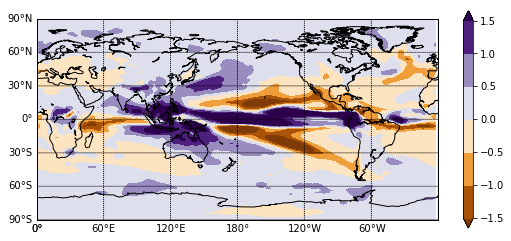

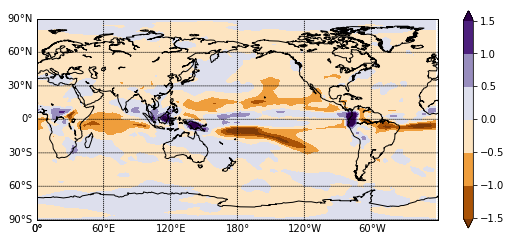

In [14]:
# Variable to be used to get data
var = 'pr'

# set contour and colorbar levels. With symmetric levels we'll get a symmetric colorbar.
levels = level_func(-1.5,1.5,0.5)

# choose an appropriate colorbar
# https://matplotlib.org/examples/color/colormaps_reference.html
cmap = plt.cm.PuOr

plot_data_1 = all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']
plot_data_2 = all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean']

# plot the CO2 anomaly
m, x, y = map_setup(lons, lats)
m.contourf(x,y,plot_data_1, cmap=cmap, levels=levels, extend='both')
plt.colorbar(ticks=levels, extend='both')
plt.show() # we need to use this command if we are plotting multiple times in each window

# plot the CO2&100%Geo anomaly
m, x, y = map_setup(lons, lats)
m.contourf(x,y,plot_data_2, cmap=cmap, levels=levels, extend='both')
plt.colorbar(ticks=levels, extend='both')
plt.show() # we need to use this command if we are plotting multiple times in each window

### solar geoengineering changes the hydrological cycle considerably!
These maps make clear that solar geoengineering deployed to offset all global mean temperature change (100%Geo) doesn't simply reverse the effects of global warming on the hydrological cycle. There are large residual changes in precipitation around the world.

# Histograms of anomalies

The histogram of these anomalies will give us a very different look at the data.

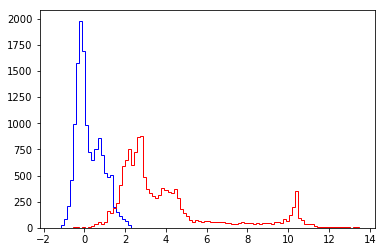

In [15]:
var = 'tas'

# CO2 - control anomaly
plot_data_1 = (all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']).flatten() # Flatten turns multi-D to 1D data
# CO2&100%geo - control anomaly
plot_data_2 = (all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean']).flatten()

plot_data = [plot_data_1, plot_data_2]

# Red for CO2 - control, blue for CO2&100%Geo
colors = ['r','b']

plt.hist(plot_data, bins=100, histtype='step', color=colors)
plt.show()

A problem with the above plot is that all gridcells are treated equally. As this is a lon-lat grid model, the tiny polar ocean gridcells are given the same weight as the large, tropical gridcells.

Because we aren't equally interested in each gridcell we want to weight the results. We'll produce 4 different weightings:
- global area weighting
- land area weighting
- population weighting (GPW4 2015 population dataset)
- agricultural weighting (cropland and pasture areas in the year 2000)

In [16]:
"""
Load the data for each weighting from a netcdf file.
Normalize so that the weighting sums to one.
"""

### GLOBAL AREA ###
# Open the netcdf file, load the correct variable, output to array and squeeze() to get rid of degenerate dimensions
area_weight = Dataset('data/NorESM1-M_grid_weight.nc').variables['cell_weights'][:].squeeze()
# Area_weight already sums to 1 so we don't need to normalize.

### LAND AREA ###
# Load up the land fraction in the same way
land_fraction = Dataset('data/NorESM1-M_land_fraction.nc').variables['sftlf'][:].squeeze()
# use this data to mask out the global area_weight
land_area_weight = area_weight * land_fraction
# Normalize so that the sum of all points is 1.
land_area_weight = land_area_weight / np.sum(land_area_weight)

### POPULATION ###
# load the population dataset.
pop = Dataset('data/NorESM1-M_pop.nc').variables['pop'][:].squeeze()
pop_weight = pop / np.sum(pop)

### AGRICULTURAL AREA ###
# Do the same for agriculture weighting
agri = Dataset('data/NorESM1-M_agriculture.nc').variables['fraction'][:].squeeze()
agri_weight = agri / np.sum(agri)

Now let's look at the difference these weightings can make.

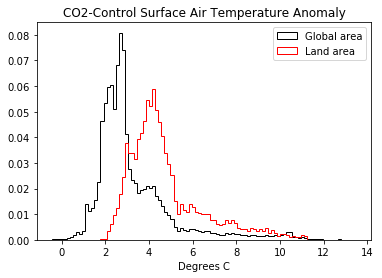

In [17]:
"""
Let's plot the CO2 - control anomaly with global and land area-weighting
"""
var = 'tas'

plot_data = all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']
# "flatten" the data from 2D to 1D
plot_data = plot_data.flatten()

# We need to flatten the weights too.
# Let's plot the global area in black and land area in red
global_area = plt.hist(plot_data, bins=100, histtype='step', weights=area_weight.flatten(), color='k', label='Global area')
land_area = plt.hist(plot_data, bins=100, histtype='step', weights=land_area_weight.flatten(), color='r', label='Land area')

plt.legend()
plt.title('CO2-Control Surface Air Temperature Anomaly')
plt.xlabel('Degrees C')
plt.show()

We can see that area-weighting removes the spike we saw at +10C in the last plot. We can also see that almost all the lowest values belongs to ocean gridcells.

Now let's compare the land-area surface air temperature anomalies for CO2 - control and CO2&100%Geo - Control.

## Figure 2 - Histograms of surface air temperature anomalies over land

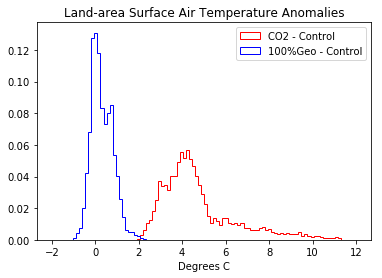

In [18]:
# variable to plot
var = 'tas'

# We'll need to specify a plot range so that our two plots use the same bins.
plot_range = [-2,12]

# CO2 - control anomaly
plot_data_1 = all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']
plot_data_1 = plot_data_1.flatten()
# CO2&100%geo - control anomaly
plot_data_2 = all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean']
plot_data_2 = plot_data_2.flatten()

weight = land_area_weight.flatten()

# plot = plt.hist(plot_data, bins=100, histtype='step', weights=weights, color=colors, labels=['CO2 - Control', 'CO2&100%Geo - Control'])
# # plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='CO2&100%Geo - Control')
plot_1 = plt.hist(plot_data_1, bins=100, histtype='step', weights=weight, color='r', label='CO2 - Control', range=plot_range)
plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='100%Geo - Control', range=plot_range)

plt.legend()
plt.title('Land-area Surface Air Temperature Anomalies')
plt.xlabel('Degrees C')
plt.show()

Copy the contents from the cell above into the cell below this one and edit the variable and range to produce a similar plot for precipitation.

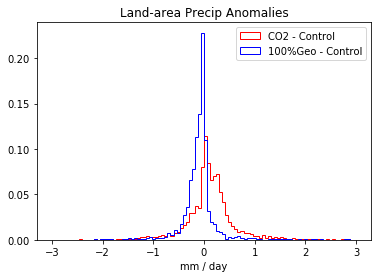

In [20]:
# variable to plot
var = 'pr'

# We'll need to specify a plot range so that our two plots use the same bins.
plot_range = [-3,3]

# CO2 - control anomaly
plot_data_1 = all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']
plot_data_1 = plot_data_1.flatten()
# CO2&100%geo - control anomaly
plot_data_2 = all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean']
plot_data_2 = plot_data_2.flatten()

weight = land_area_weight.flatten()

# plot = plt.hist(plot_data, bins=100, histtype='step', weights=weights, color=colors, labels=['CO2 - Control', 'CO2&100%Geo - Control'])
# # plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='CO2&100%Geo - Control')
plot_1 = plt.hist(plot_data_1, bins=100, histtype='step', weights=weight, color='r', label='CO2 - Control', range=plot_range)
plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='100%Geo - Control', range=plot_range)

plt.legend()
plt.title('Land-area Precip Anomalies')
plt.xlabel('mm / day')
plt.show()

The largest changes in rainfall will occur in regions which have lots of rainfall. Let's look at these anomalies in two other ways: percentage change and normalized by the control standard deviation.

Copy the code from above into the two cells below and modify the plot_data field to produce percentage and standard deviation anomalies.

TIP - all_data[exp,var,'std'] contains the standard deviation of all points for the specified experiment and variable.

### precipitation percentage anomaly plots.

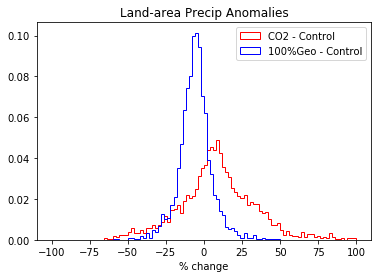

In [25]:
# variable to plot
var = 'pr'

# We'll need to specify a plot range so that our two plots use the same bins.
plot_range = [-100,100]

# CO2 - control anomaly
plot_data_1 = 100.0 * ((all_data['CO2',var,'mean'] / all_data['ctl',var,'mean']) - 1.0)
plot_data_1 = plot_data_1.flatten()
# CO2&100%geo - control anomaly
plot_data_2 = 100.0 * ((all_data['Geo100',var,'mean'] / all_data['ctl',var,'mean']) - 1.0)
plot_data_2 = plot_data_2.flatten()

weight = land_area_weight.flatten()

# plot = plt.hist(plot_data, bins=100, histtype='step', weights=weights, color=colors, labels=['CO2 - Control', 'CO2&100%Geo - Control'])
# # plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='CO2&100%Geo - Control')
plot_1 = plt.hist(plot_data_1, bins=100, histtype='step', weights=weight, color='r', label='CO2 - Control', range=plot_range)
plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='100%Geo - Control', range=plot_range)

plt.legend()
plt.title('Land-area Precip Anomalies')
plt.xlabel('% change')
plt.show()

### precipitation standard deviation anomaly plots.

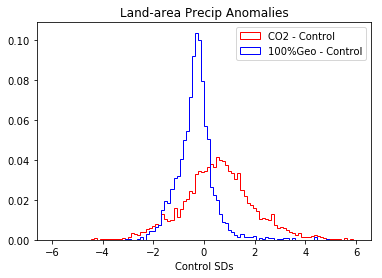

In [28]:
# variable to plot
var = 'pr'

# We'll need to specify a plot range so that our two plots use the same bins.
plot_range = [-6,6]

# CO2 - control anomaly
plot_data_1 = (all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']) / all_data['ctl',var,'std']
plot_data_1 = plot_data_1.flatten()
# CO2&100%geo - control anomaly
plot_data_2 = (all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean']) / all_data['ctl',var,'std']
plot_data_2 = plot_data_2.flatten()

weight = land_area_weight.flatten()

# plot = plt.hist(plot_data, bins=100, histtype='step', weights=weights, color=colors, labels=['CO2 - Control', 'CO2&100%Geo - Control'])
# # plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='CO2&100%Geo - Control')
plot_1 = plt.hist(plot_data_1, bins=100, histtype='step', weights=weight, color='r', label='CO2 - Control', range=plot_range)
plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='100%Geo - Control', range=plot_range)

plt.legend()
plt.title('Land-area Precip Anomalies')
plt.xlabel('Control SDs')
plt.show()

# What fraction of the world does solar geoengineering make Better or Worse off?

Let's assume that a region is better off after geoengineering if it experiences a reduction in the magnitude of climate change. What fraction of the land-area is better off for each variable?

To work this out we're going to need to calculate the difference in absolute anomalies and calculate the fraction of the land area where this difference is positive and negative.

In [29]:
# We'll use the land area weight
weight = land_area_weight

# Loop over all variables:
for var in var_list:
    
    # calculate the absolute anomalies:
    abs_CO2_anom = abs(all_data['CO2',var,'mean'] - all_data['ctl',var,'mean'])
    abs_Geo100_anom = abs(all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean'])
    
    #  calculate which anomaly is larger in each gridcell
    better_cells = abs_CO2_anom > abs_Geo100_anom
    worse_cells = abs_CO2_anom <= abs_Geo100_anom
    
    # calculate the fraction of the land area that is better / worse off.
    percent_better = 100.0 * np.sum(better_cells * weight)
    percent_worse = 100.0 * np.sum(worse_cells * weight)
    
    print 'for',var, '{:04.2f}'.format(percent_better), '% are better off and {:04.2f} % are worse off'.format(percent_worse)

for tas 100.00 % are better off and 0.00 % are worse off
for txx 99.67 % are better off and 0.33 % are worse off
for pr 68.79 % are better off and 31.21 % are worse off
for rx5day 70.90 % are better off and 29.10 % are worse off
for p-e 74.08 % are better off and 25.92 % are worse off


What fraction of these changes are statistically significant? We can test this by using the student's T-Test. We will use the two absolute anomalies as our two means and the standard deviations of CO2 and Geo100 as our standard deviations. the averages and standard deviations are calculated over 40 years.

## Table 1 - Fraction of the land area better, worse and uncertain

In [30]:
var = 'pr'

weight = land_area_weight

ttest_level = 0.05 # (95% confidence)

# calculate the absolute anomalies:
abs_CO2_anom = abs(all_data['CO2',var,'mean'] - all_data['ctl',var,'mean'])
abs_Geo100_anom = abs(all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean'])

CO2_std = all_data['CO2',var,'std']
Geo100_std = all_data['Geo100',var,'std']

nyears = 40

ttest = ttest_sub(abs_CO2_anom, CO2_std, nyears, abs_Geo100_anom, Geo100_std, nyears) < ttest_level

#  calculate which anomaly is larger in each gridcell
better_cells = abs_CO2_anom > abs_Geo100_anom
worse_cells = abs_CO2_anom <= abs_Geo100_anom

# calculate the fraction of the land area that is better / worse off.
percent_uncertain = 100.0 * np.sum(weight * np.logical_not(ttest))
percent_better = 100.0 * np.sum(better_cells * weight * ttest)
percent_worse = 100.0 * np.sum(worse_cells * weight * ttest)

print 'for', var_longname[var]
print '{:04.2f} % are better off'.format(percent_better)
print '{:04.2f} % are worse off'.format(percent_worse)
print '{:04.2f} % we don\'t know'.format(percent_uncertain)

for Precipitation
48.22 % are better off
13.56 % are worse off
38.22 % we don't know


Copy the above cell into the cell below and modify it so that it loops over all variables. 

TIP: "for var in var_list:" will start the loop, you will then need to indent all code that is inside the loop. Select the code and hit "TAB" to get the correct indent.

In [47]:
weight = land_area_weight

ttest_level = 0.05 # (95% confidence)

for var in var_list:
    # calculate the absolute anomalies:
    abs_CO2_anom = abs(all_data['CO2',var,'mean'] - all_data['ctl',var,'mean'])
    abs_Geo100_anom = abs(all_data['Geo100',var,'mean'] - all_data['ctl',var,'mean'])

    CO2_std = all_data['CO2',var,'std']
    Geo100_std = all_data['Geo100',var,'std']

    nyears = 40

    ttest = ttest_sub(abs_CO2_anom, CO2_std, nyears, abs_Geo100_anom, Geo100_std, nyears) < ttest_level

    #  calculate which anomaly is larger in each gridcell
    better_cells = abs_CO2_anom > abs_Geo100_anom
    worse_cells = abs_CO2_anom <= abs_Geo100_anom

    # calculate the fraction of the land area that is better / worse off.
    percent_uncertain = 100.0 * np.sum(weight * np.logical_not(ttest))
    percent_better = 100.0 * np.sum(better_cells * weight * ttest)
    percent_worse = 100.0 * np.sum(worse_cells * weight * ttest)

    print 'for', var_longname[var]
    print '{:04.2f} % are better off'.format(percent_better)
    print '{:04.2f} % are worse off'.format(percent_worse)
    print '{:04.2f} % we don\'t know'.format(percent_uncertain)

for 2m Temperature
0.00 % are better off
0.00 % are worse off
100.00 % we don't know
for Max 2m Temperature
98.81 % are better off
0.04 % are worse off
1.16 % we don't know
for Precipitation
48.22 % are better off
13.56 % are worse off
38.22 % we don't know
for 5-Day Max Precip.
34.49 % are better off
5.49 % are worse off
60.02 % we don't know
for Precip. - Evap.
36.82 % are better off
5.81 % are worse off
57.38 % we don't know


Try changing the weighting, does this change the main findings?

# Different levels of geoengineering

When evaluating the climate response to solar geoengineering it's important to consider how things would differ if solar geoengineering were deployed differently. We are looking at a solar constant reduction so the only degree of freedom we have is how much of a reduction in solar constant we consider.

We can investigate this by interpolating between the CO2 and CO2&100%Geo scenario to produce intermediate scenarios. The function below does this. 

In [49]:
def geo_fraction_data(fraction, var, stat):
    CO2_data = all_data['CO2',var,stat]
    Geo100_data = all_data['Geo100',var,stat]
    return CO2_data + fraction * (Geo100_data - CO2_data)

Using this function you can now produce the results we generated above for different levels of solar geoengineering. Instead of "all_data['Geo100',var,stat]" you can use "geo_fraction_data(0.5, var, stat)" to get data for a scenario which offsets 50% of the warming from elevated CO2 levels. 
NOTE - we need curved rather than squared brackets as it's a function rather than a dictionary.

Copy the code from figure 2 into the cell below and add a new line to the plot for a different level of Geoengineering using this new function. 

TIP: entering 'g' for color will give you a green line

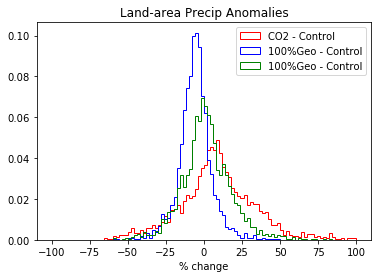

In [50]:
# variable to plot
var = 'pr'

# We'll need to specify a plot range so that our two plots use the same bins.
plot_range = [-100,100]

# CO2 - control anomaly
plot_data_1 = 100.0 * ((all_data['CO2',var,'mean'] / all_data['ctl',var,'mean']) - 1.0)
plot_data_1 = plot_data_1.flatten()
# CO2&100%geo - control anomaly
plot_data_2 = 100.0 * ((all_data['Geo100',var,'mean'] / all_data['ctl',var,'mean']) - 1.0)
plot_data_2 = plot_data_2.flatten()
# CO2&100%geo - control anomaly
plot_data_3 = 100.0 * ((geo_fraction_data(0.5, var, 'mean') / all_data['ctl',var,'mean']) - 1.0)
plot_data_3 = plot_data_3.flatten()

weight = land_area_weight.flatten()

# plot = plt.hist(plot_data, bins=100, histtype='step', weights=weights, color=colors, labels=['CO2 - Control', 'CO2&100%Geo - Control'])
# # plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='CO2&100%Geo - Control')
plot_1 = plt.hist(plot_data_1, bins=100, histtype='step', weights=weight, color='r', label='CO2 - Control', range=plot_range)
plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='100%Geo - Control', range=plot_range)
plot_3 = plt.hist(plot_data_3, bins=100, histtype='step', weights=weight, color='g', label='100%Geo - Control', range=plot_range)

plt.legend()
plt.title('Land-area Precip Anomalies')
plt.xlabel('% change')
plt.show()

Copy the code from table 1 below and modify it to calculate the fraction made better / worse off for a different level of solar geoengineering.

In [51]:
weight = land_area_weight

ttest_level = 0.05 # (95% confidence)

for var in var_list:
    # calculate the absolute anomalies:
    abs_CO2_anom = abs(all_data['CO2',var,'mean'] - all_data['ctl',var,'mean'])
    abs_Geo100_anom = abs(geo_fraction_data(0.5, var, 'mean') - all_data['ctl',var,'mean'])

    CO2_std = all_data['CO2',var,'std']
    Geo100_std = all_data['Geo100',var,'std']

    nyears = 40

    ttest = ttest_sub(abs_CO2_anom, CO2_std, nyears, abs_Geo100_anom, Geo100_std, nyears) < ttest_level

    #  calculate which anomaly is larger in each gridcell
    better_cells = abs_CO2_anom > abs_Geo100_anom
    worse_cells = abs_CO2_anom <= abs_Geo100_anom

    # calculate the fraction of the land area that is better / worse off.
    percent_uncertain = 100.0 * np.sum(weight * np.logical_not(ttest))
    percent_better = 100.0 * np.sum(better_cells * weight * ttest)
    percent_worse = 100.0 * np.sum(worse_cells * weight * ttest)

    print 'for', var_longname[var]
    print '{:04.2f} % are better off'.format(percent_better)
    print '{:04.2f} % are worse off'.format(percent_worse)
    print '{:04.2f} % we don\'t know'.format(percent_uncertain)

for 2m Temperature
0.00 % are better off
0.00 % are worse off
100.00 % we don't know
for Max 2m Temperature
99.47 % are better off
0.00 % are worse off
0.53 % we don't know
for Precipitation
47.78 % are better off
2.76 % are worse off
49.46 % we don't know
for 5-Day Max Precip.
22.30 % are better off
0.57 % are worse off
77.13 % we don't know
for Precip. - Evap.
26.73 % are better off
1.32 % are worse off
71.95 % we don't know


# 2D Histograms

We can plot the CO2 and Geo anomalies together using a 2D histogram to better understand the relationship between these distributions. If we plot the CO2 anomaly along the X axis and the Geo anomaly along the Y axis then any gridcells which fall above the 1:1 line have seen greater change and any which fall below will have seen less change.

The function below will plot guide lines at zero, 1:1, and -1:-1 - points between these lines will be where solar geonegineering has reduced the magnitude of change and points outside will have increased the magnitude of change.

In [52]:
def guide_lines(plot_range):
    
    # plot zero lines
    plt.axvline(0, color='k')
    plt.axhline(0, color='k')
    
    # plot 1:1 and -1:-1 lines
    ax_max = max( max(plot_range[0]), max(plot_range[1]) )
    ax_min = min( min(plot_range[0]), min(plot_range[1]) )
    
    plt.plot([ax_min, ax_max],[ax_min,ax_max], color='k')
    plt.plot([ax_min, -1.0 * ax_min],[-1.0 * ax_min, ax_min], color='k')

Now let's plot the standard deviation normalized precipitation anomalies

## Figure 3 - 2D histogram of standard-deviation normalized precipitation anomalies.

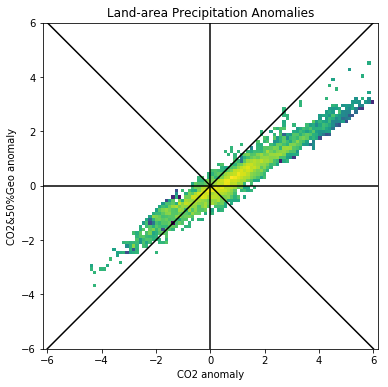

In [53]:
# variable to plot
var = 'pr'

# We'll need to specify a plot range so that our two plots use the same bins.
plot_range = ([-6,6],[-6,6])

# CO2 - control anomaly for X-axis
plot_data_x = (all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']) / all_data['ctl',var,'std']
plot_data_x = plot_data_x.flatten()

# CO2&50%geo - control anomaly for Y-axis
plot_data_y = (geo_fraction_data(0.5, var, 'mean') - all_data['ctl',var,'mean']) / all_data['ctl',var,'std']
plot_data_y = plot_data_y.flatten()

weight = land_area_weight.flatten()

fig = plt.figure(figsize=(6,6))

plt.hist2d(plot_data_x, plot_data_y, bins=100, range=plot_range, norm=LogNorm(), weights=weight)
    
guide_lines(plot_range)

plt.title('Land-area Precipitation Anomalies')
plt.xlabel('CO2 anomaly')
plt.ylabel('CO2&50%Geo anomaly')
plt.axis('equal')

plt.show()

The gridcells outside the 1:1 lines are worse off. This plot shows that most regions made worse off in terms of precipitation are drier. Copy the code from above and plot the same thing for P-E. What difference do you notice?

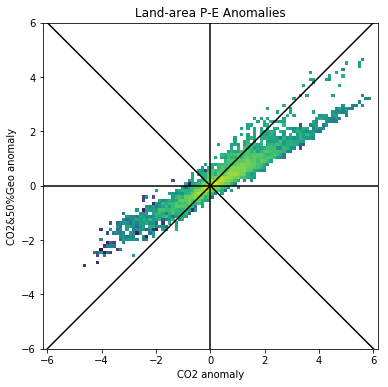

In [55]:
# variable to plot
var = 'p-e'

# We'll need to specify a plot range so that our two plots use the same bins.
plot_range = ([-6,6],[-6,6])

# CO2 - control anomaly for X-axis
plot_data_x = (all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']) / all_data['ctl',var,'std']
plot_data_x = plot_data_x.flatten()

# CO2&50%geo - control anomaly for Y-axis
plot_data_y = (geo_fraction_data(0.5, var, 'mean') - all_data['ctl',var,'mean']) / all_data['ctl',var,'std']
plot_data_y = plot_data_y.flatten()

weight = land_area_weight.flatten()

fig = plt.figure(figsize=(6,6))

plt.hist2d(plot_data_x, plot_data_y, bins=100, range=plot_range, norm=LogNorm(), weights=weight)
    
guide_lines(plot_range)

plt.title('Land-area P-E Anomalies')
plt.xlabel('CO2 anomaly')
plt.ylabel('CO2&50%Geo anomaly')
plt.axis('equal')

plt.show()

# Absolute anomaly histograms

Copy the code from figure 2 into the cell below and modify it to show the difference in the absolute CO2 and CO2&Geo anomalies for your chosen level of geoengineering. This plot shows how much better / worse off different areas are made by geoengineering. 

TIP - calculate the absolute anomalies first then define "plot_data" as the difference between them.

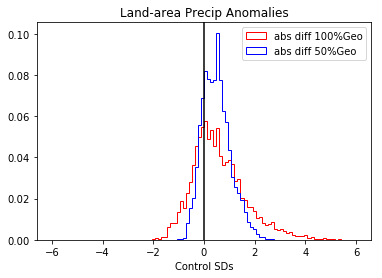

In [57]:
# variable to plot
var = 'pr'

# We'll need to specify a plot range so that our two plots use the same bins.
plot_range = [-6,6]

# CO2 - control anomaly
abs_CO2_anom = abs((all_data['CO2',var,'mean'] - all_data['ctl',var,'mean']) / all_data['ctl',var,'std'])
abs_100geo_anom = abs((geo_fraction_data(1.0, var, 'mean') - all_data['ctl',var,'mean']) / all_data['ctl',var,'std'])
abs_50geo_anom = abs((geo_fraction_data(0.5, var, 'mean') - all_data['ctl',var,'mean']) / all_data['ctl',var,'std'])

plot_data_1 = (abs_CO2_anom - abs_100geo_anom).flatten()
plot_data_2 = (abs_CO2_anom - abs_50geo_anom).flatten()

weight = land_area_weight.flatten()

# plot = plt.hist(plot_data, bins=100, histtype='step', weights=weights, color=colors, labels=['CO2 - Control', 'CO2&100%Geo - Control'])
# # plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='CO2&100%Geo - Control')
plot_1 = plt.hist(plot_data_1, bins=100, histtype='step', weights=weight, color='r', label='abs diff 100%Geo', range=plot_range)
plot_2 = plt.hist(plot_data_2, bins=100, histtype='step', weights=weight, color='b', label='abs diff 50%Geo', range=plot_range)

plt.axvline(0.0, color='k')
plt.legend()
plt.title('Land-area Precip Anomalies')
plt.xlabel('Control SDs')
plt.show()

# Try masking out data in the plots.

You can mask the datasets using boolean arrays. Any comparison A > B, etc. creates a boolean array, including the ttest I used in the Table 1 section. In the plots above it's simple to mask the data out. All you need to do is the following:
- First define your mask in a new line in the appropriate place (e.g. mask = plot_data > 0, after defining plot_data)
- Then add a line applying the mask to the data you want. This is done as follows: plot_data = plot_data[mask].
- Then apply the same mask to the weights, weight = weight[mask].
- Then run your code.

You could try applying a T-Test masking to the 2D histograms or absolute anomaly histograms.

# Any other ideas for plots?

You should have the tools to try out different ideas for evaluating the climate response to solar geoengineering. Have fun!